In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
path = '/content/drive/MyDrive/DSA3101_Share/'

In [ ]:
df = pd.read_csv(path+'2006_to_2008_preprocessed.csv')

In [ ]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,TailNum,CRSElapsedTime,Origin,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,Arr_Delay_boolean
0,2006,1,11,3,745,1018,US,N657AW,273.0,ATL,...,NaN,NaN,NaN,2006-01-11T08:27:13,2006-01-11T17:50:23,0.39,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,rain,1
1,2006,1,11,3,1053,1318,US,N834AW,265.0,ATL,...,NaN,NaN,NaN,2006-01-11T08:27:13,2006-01-11T17:50:23,0.39,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,rain,0
2,2006,1,11,3,1915,2133,US,N605AW,258.0,ATL,...,NaN,NaN,NaN,2006-01-11T08:27:13,2006-01-11T17:50:23,0.39,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,rain,0
3,2006,1,11,3,1755,1933,US,N312AW,158.0,AUS,...,NaN,NaN,NaN,2006-01-11T07:28:38,2006-01-11T17:49:31,0.41,Clear,Clear conditions throughout the day.,clear-day,0
4,2006,1,11,3,832,1015,US,N309AW,163.0,AUS,...,NaN,NaN,NaN,2006-01-11T07:28:38,2006-01-11T17:49:31,0.41,Clear,Clear conditions throughout the day.,clear-day,0


In [ ]:
df.drop(['solarradiation','solarenergy','uvindex','severerisk'], axis=1, inplace=True)

In [ ]:
df.drop(['precipprob','preciptype','icon'],axis=1, inplace=True)

In [ ]:
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].astype('category')

# Replace missing categorical (factor) values with 'unknown'
for col in df.select_dtypes(include=['category']):
    df[col] = df[col].cat.add_categories(['unknown'])
    df[col].fillna('unknown', inplace=True)

# Replace missing numeric values with mean of that column
for col in df.select_dtypes(include=[np.number]):
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

In [ ]:
df.dtypes

Year                    int64
Month                   int64
DayofMonth              int64
DayOfWeek               int64
CRSDepTime              int64
CRSArrTime              int64
UniqueCarrier        category
TailNum              category
CRSElapsedTime        float64
Origin               category
Dest                 category
Distance                int64
origin_state         category
tempmax               float64
tempmin               float64
temp                  float64
feelslikemax          float64
feelslikemin          float64
feelslike             float64
dew                   float64
humidity              float64
precip                float64
precipcover           float64
snow                  float64
snowdepth             float64
windgust              float64
windspeed             float64
winddir               float64
sealevelpressure      float64
cloudcover            float64
visibility            float64
sunrise              category
sunset               category
moonphase 

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_encoded = pd.get_dummies(df, columns=['UniqueCarrier','conditions'])
le = LabelEncoder()
cat_columns = ['TailNum','Origin','Dest','origin_state','sunrise','sunset','description']
for column in cat_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

In [15]:
X = df_encoded.drop("Arr_Delay_boolean", axis=1)
y = df_encoded["Arr_Delay_boolean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

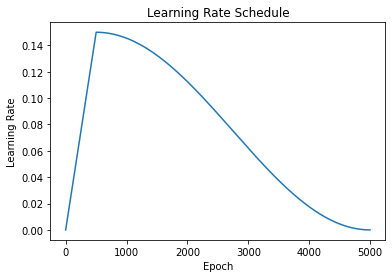

In [20]:
import math
import matplotlib.pyplot as plt

def lr_schedule(epoch):
    warmup_epochs = 500
    base_lr = 0.15
    max_epochs = 5000
    if epoch < warmup_epochs:
        return base_lr * epoch / warmup_epochs
    else:
        cosine_decay = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (max_epochs - warmup_epochs)))
        return base_lr * cosine_decay

lr_rates = []
for epoch in range(5000):
    lr = lr_schedule(epoch)
    lr_rates.append(lr)

plt.plot(lr_rates)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import math
params = {
    "objective": "binary:logistic",
    "max_depth": 12,
    "n_estimators": 5000,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.1,
    "reg_alpha": 0.1,
    "reg_lambda": 1,
    "scale_pos_weight": 1,
    "tree_method": "gpu_hist",
    "random_state": 42,
    "max_delta_step": 1,
    "max_bin": 512,
    "min_split_loss": 0,
    "max_leaves": 256,
}
model = xgb.XGBClassifier(**params)

# Train the model on the training data and evaluate it on the validation data
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True,
          callbacks=[xgb.callback.LearningRateScheduler(lr_schedule)],early_stopping_rounds=100)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.41033	validation_1-error:0.40929
[1]	validation_0-error:0.41033	validation_1-error:0.40929
[2]	validation_0-error:0.41032	validation_1-error:0.40929
[3]	validation_0-error:0.41032	validation_1-error:0.40929
[4]	validation_0-error:0.41032	validation_1-error:0.40929
[5]	validation_0-error:0.41031	validation_1-error:0.40927
[6]	validation_0-error:0.41032	validation_1-error:0.40928
[7]	validation_0-error:0.41032	validation_1-error:0.40928
[8]	validation_0-error:0.41025	validation_1-error:0.40922
[9]	validation_0-error:0.41019	validation_1-error:0.40915
[10]	validation_0-error:0.40987	validation_1-error:0.40882
[11]	validation_0-error:0.40945	validation_1-error:0.40841
[12]	validation_0-error:0.40927	validation_1-error:0.40824
[13]	validation_0-error:0.40909	validation_1-error:0.40812
[14]	validation_0-error:0.40902	validation_1-error:0.40804
[15]	validation_0-error:0.40859	validation_1-error:0.40764
[16]	validation_0-error:0.40841	validation_1-error:0.40746
[17]	va

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.611279 to fit


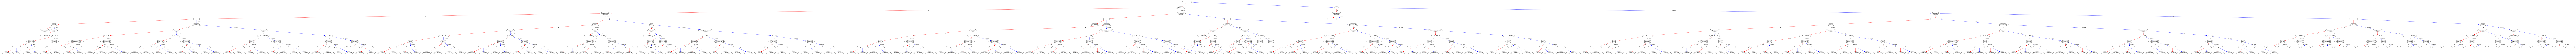

In [25]:
# Plot the first tree in the model
fig, ax = plt.subplots(figsize=(400, 200))
xgb.plot_tree(model, ax=ax, num_trees=0)
plt.show()

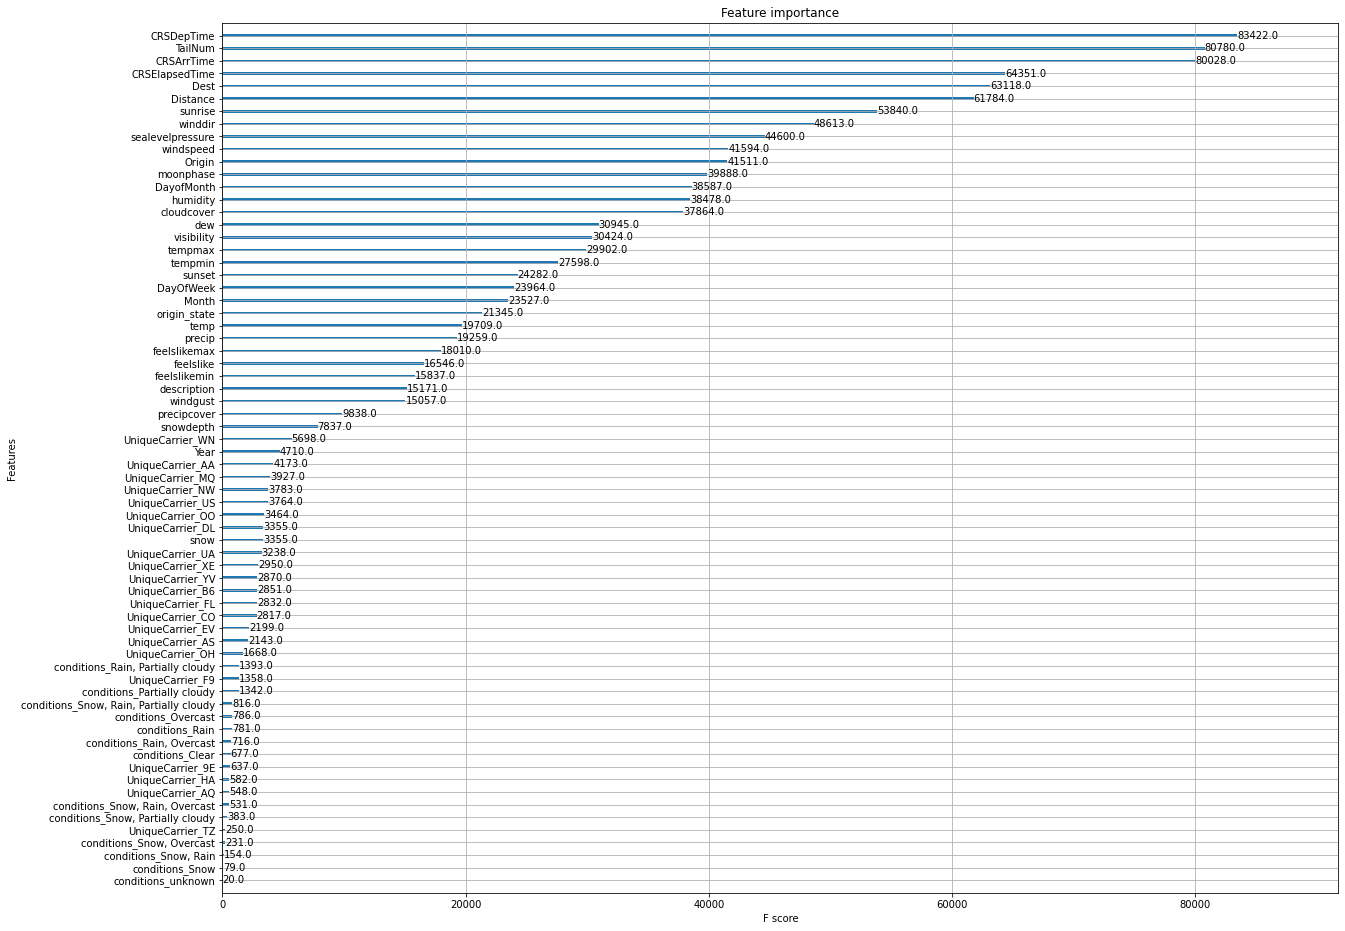

In [26]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(20, 16))
xgb.plot_importance(model, ax=ax)
plt.show()